In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import missingno
import seaborn as sb
import numpy as np

/Users/davidelks/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
df_train = pd.read_csv("./train_u6lujuX_CVtuZ9i.csv")
df_test = pd.read_csv("./test_Y3wMUE5_7gLdaTN.csv")

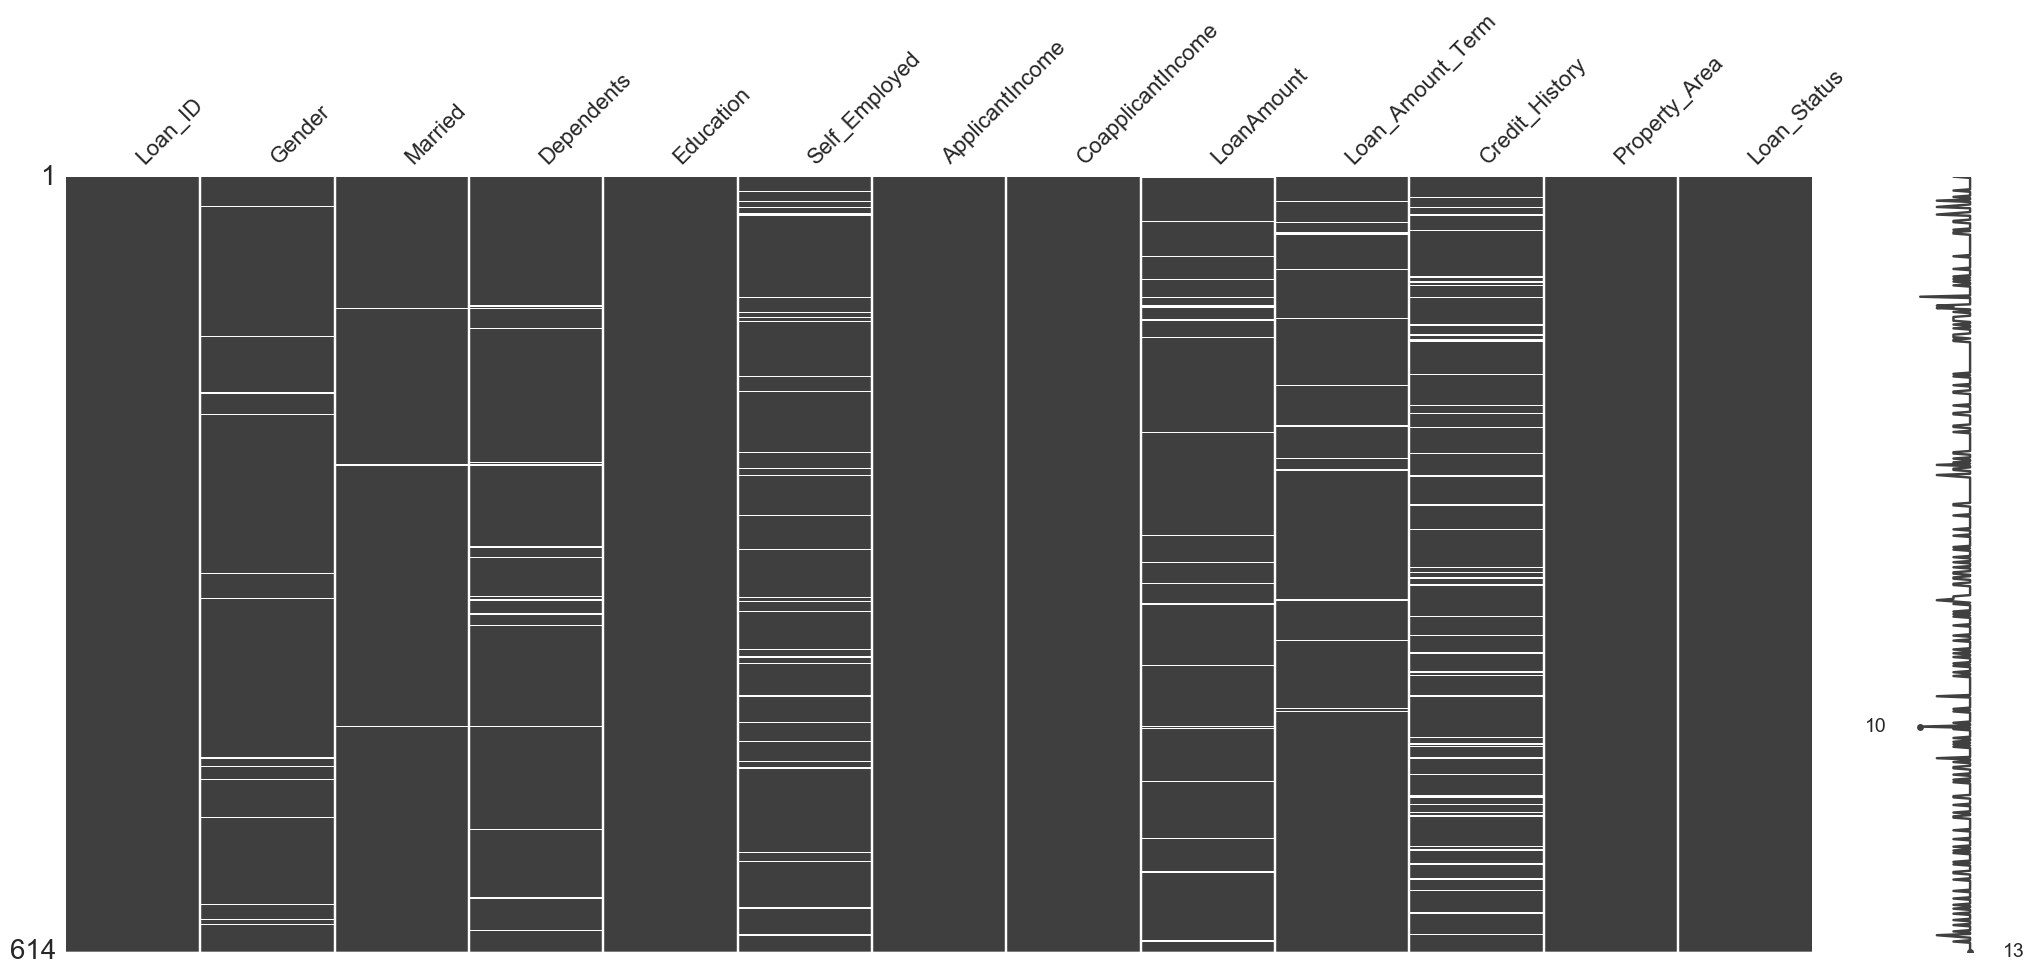

In [3]:
missingno.matrix(df_train)

In [4]:
df_train.shape

(614, 13)

In [5]:
df_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [6]:
df_train.tail()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y
613,LP002990,Female,No,0,Graduate,Yes,4583,0.0,133.0,360.0,0.0,Semiurban,N


In [7]:
df_train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115a29110>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x115b74750>]], dtype=object)

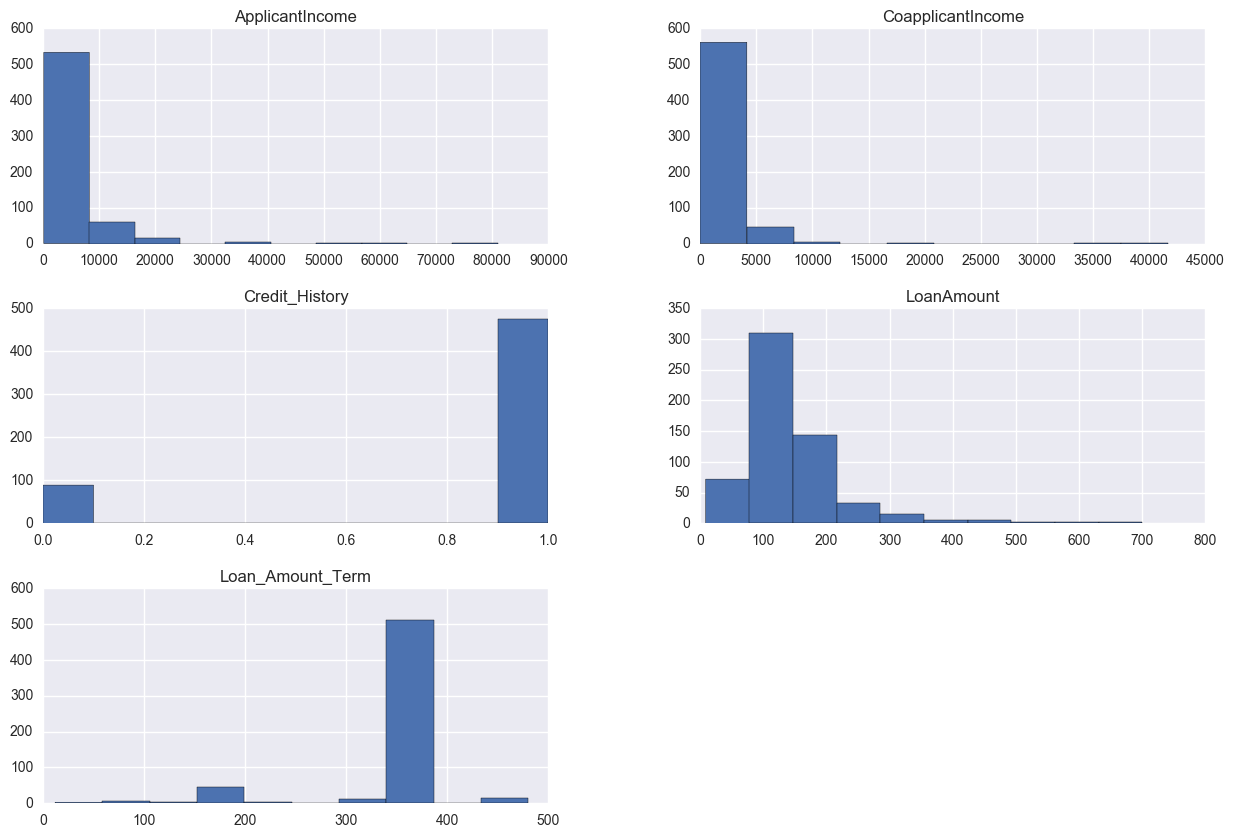

In [8]:
df_train.hist(figsize=(15, 10))

In [9]:
import altair

In [10]:
altair.Chart(df_train).mark_point().encode(
    x="Gender.N",
    y="Credit_History.Q",
    row="Loan_Status.N")

In [11]:
import pandas_profiling

In [12]:
pandas_profiling.ProfileReport(df_train)

Number of variables,13
Number of observations,614
Total Missing (%),1.9%
Total size in memory,62.4 KiB
Average record size in memory,104.1 B
Numeric,5
Categorical,7
Date,0
Text (Unique),1
Rejected,0
Distinct count,505


In [13]:
df_train.pivot_table(index="Gender")

,ApplicantIncome,CoapplicantIncome,Credit_History,LoanAmount,Loan_Amount_Term
Gender,,,,,
Female,4643.473214,1108.008929,0.831683,126.697248,352.293578
Male,5446.460123,1742.932352,0.847007,149.265957,339.665272


In [14]:
pd.crosstab(columns=df_train['Loan_Status'], index=df_train["Gender"], normalize=True)

Loan_Status,N,Y
Gender,,
Female,0.061564,0.124792
Male,0.249584,0.564060


### Let's fill in the missing data

In [15]:
df_train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [16]:
df_train.LoanAmount.describe()

count    592.000000
mean     146.412162
std       85.587325
min        9.000000
25%      100.000000
50%      128.000000
75%      168.000000
max      700.000000
Name: LoanAmount, dtype: float64

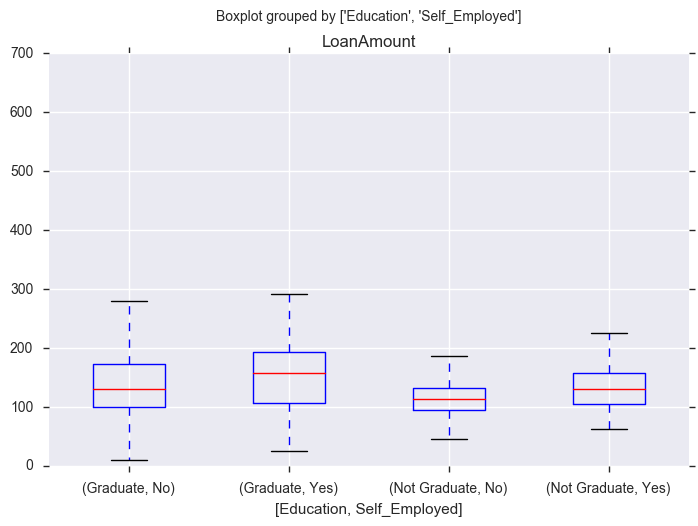

In [17]:
df_train[['Education', "Self_Employed", "LoanAmount"]].boxplot(by=["Education",'Self_Employed']);

We can use this to fill in missing details. But first we have to impute the missing details for Self_employed

In [18]:
df_train.Self_Employed.value_counts(normalize=True)

No     0.859107
Yes    0.140893
Name: Self_Employed, dtype: float64

In [19]:
df_train['Self_Employed'] = df_train['Self_Employed'].fillna("No")

In [20]:
df_train.Self_Employed.value_counts(normalize=True)

No     0.86645
Yes    0.13355
Name: Self_Employed, dtype: float64

Now we've filled that column we can create a function to fill in the missing values on LoanAmount

In [21]:
table = df_train.pivot_table(values='LoanAmount', index='Self_Employed',
                             columns='Education', aggfunc="median")
table

Education,Graduate,Not Graduate
Self_Employed,,
No,130.0,113.0
Yes,157.5,130.0


In [22]:
# Define function to return value of this pivot_table
def fage(x):
    return table.loc[x['Self_Employed'],x['Education']]
# Replace missing values
df_train['LoanAmount'].fillna(df_train[df_train['LoanAmount'].isnull()].apply(fage, axis=1), inplace=True)

In [23]:
df_train

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,130.0,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


Let's transform the loan amount data which is a skewed

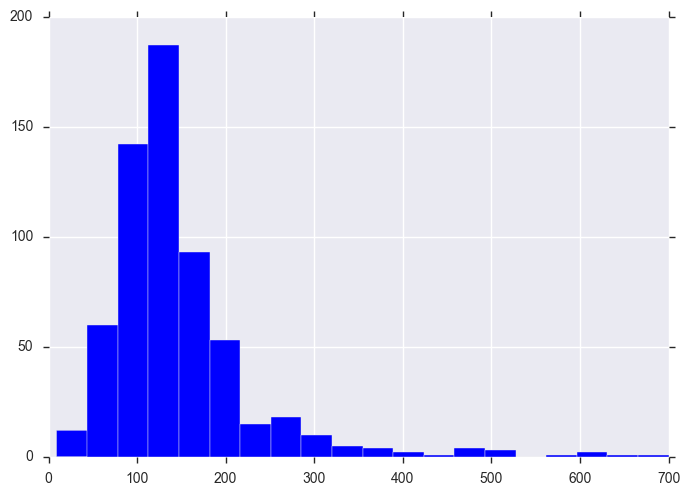

In [24]:
df_train['LoanAmount'].hist(bins=20)

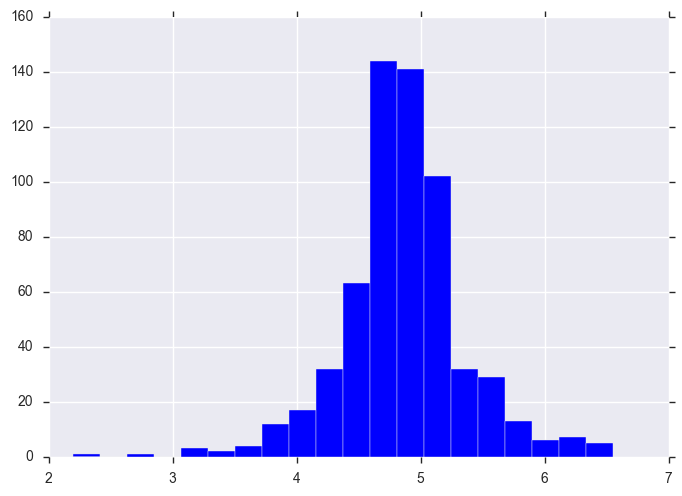

In [25]:
df_train['LoanAmount_log'] = np.log(df_train['LoanAmount'])
df_train['LoanAmount_log'].hist(bins=20)

We can do something similar to the applicant income + and perhaps it combines with CoApplicant to recognise the influence of this person in obtaining a loan

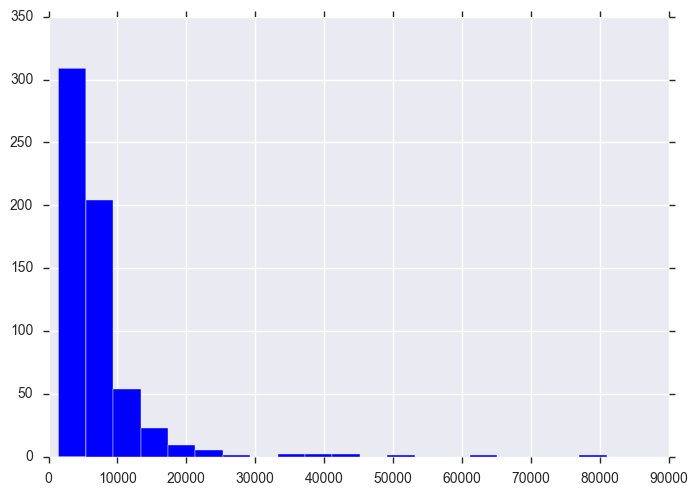

In [26]:
df_train['total_income'] = df_train.ApplicantIncome + df_train.CoapplicantIncome
df_train.total_income.hist(bins=20)

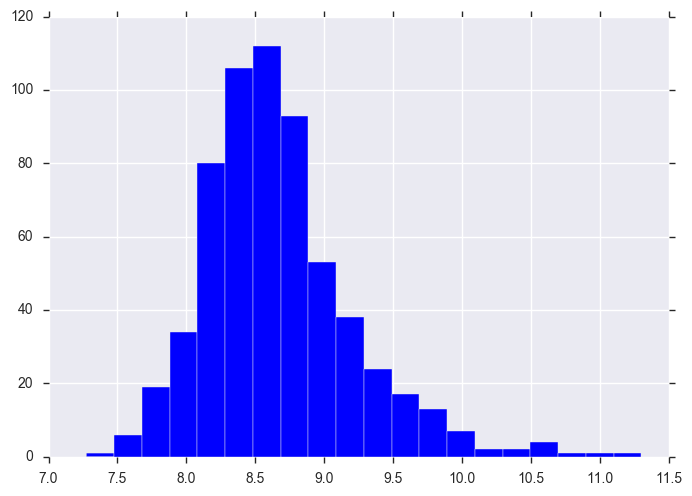

In [27]:
df_train['total_income_log'] = df_train.total_income.apply(lambda x: np.log(x))
df_train['total_income_log'].hist(bins=20)

Now to look at gender. The hunch is that there may be a link between loan amount and sex.

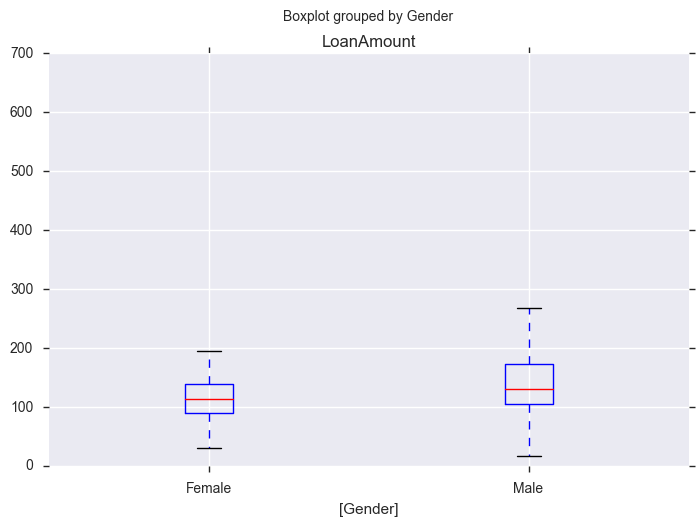

In [28]:
df_train[['Gender', "LoanAmount"]].boxplot(by=["Gender"]);

It looks reasonable. Let's pivot the data and then use that to impute the sex based on loan amount

In [29]:
piv = df_train.pivot_table(values='LoanAmount', index='Gender', aggfunc="median")
piv

Gender
Female    113.0
Male      130.0
Name: LoanAmount, dtype: float64

In [30]:
def fill_func(data):
    return "Female" if abs(data['LoanAmount'] - 113) >= abs(data['LoanAmount'] - 130) else "Male"
# Replace missing values
df_train['LoanAmount'].fillna(df_train[df_train['Gender'].isnull()].apply(fill_func, axis=1), inplace=True)

Now for married

In [31]:
pandas_profiling.ProfileReport(df_train)

Number of variables,16
Number of observations,614
Total Missing (%),1.0%
Total size in memory,76.8 KiB
Average record size in memory,128.1 B
Numeric,8
Categorical,7
Date,0
Text (Unique),1
Rejected,0
Distinct count,505


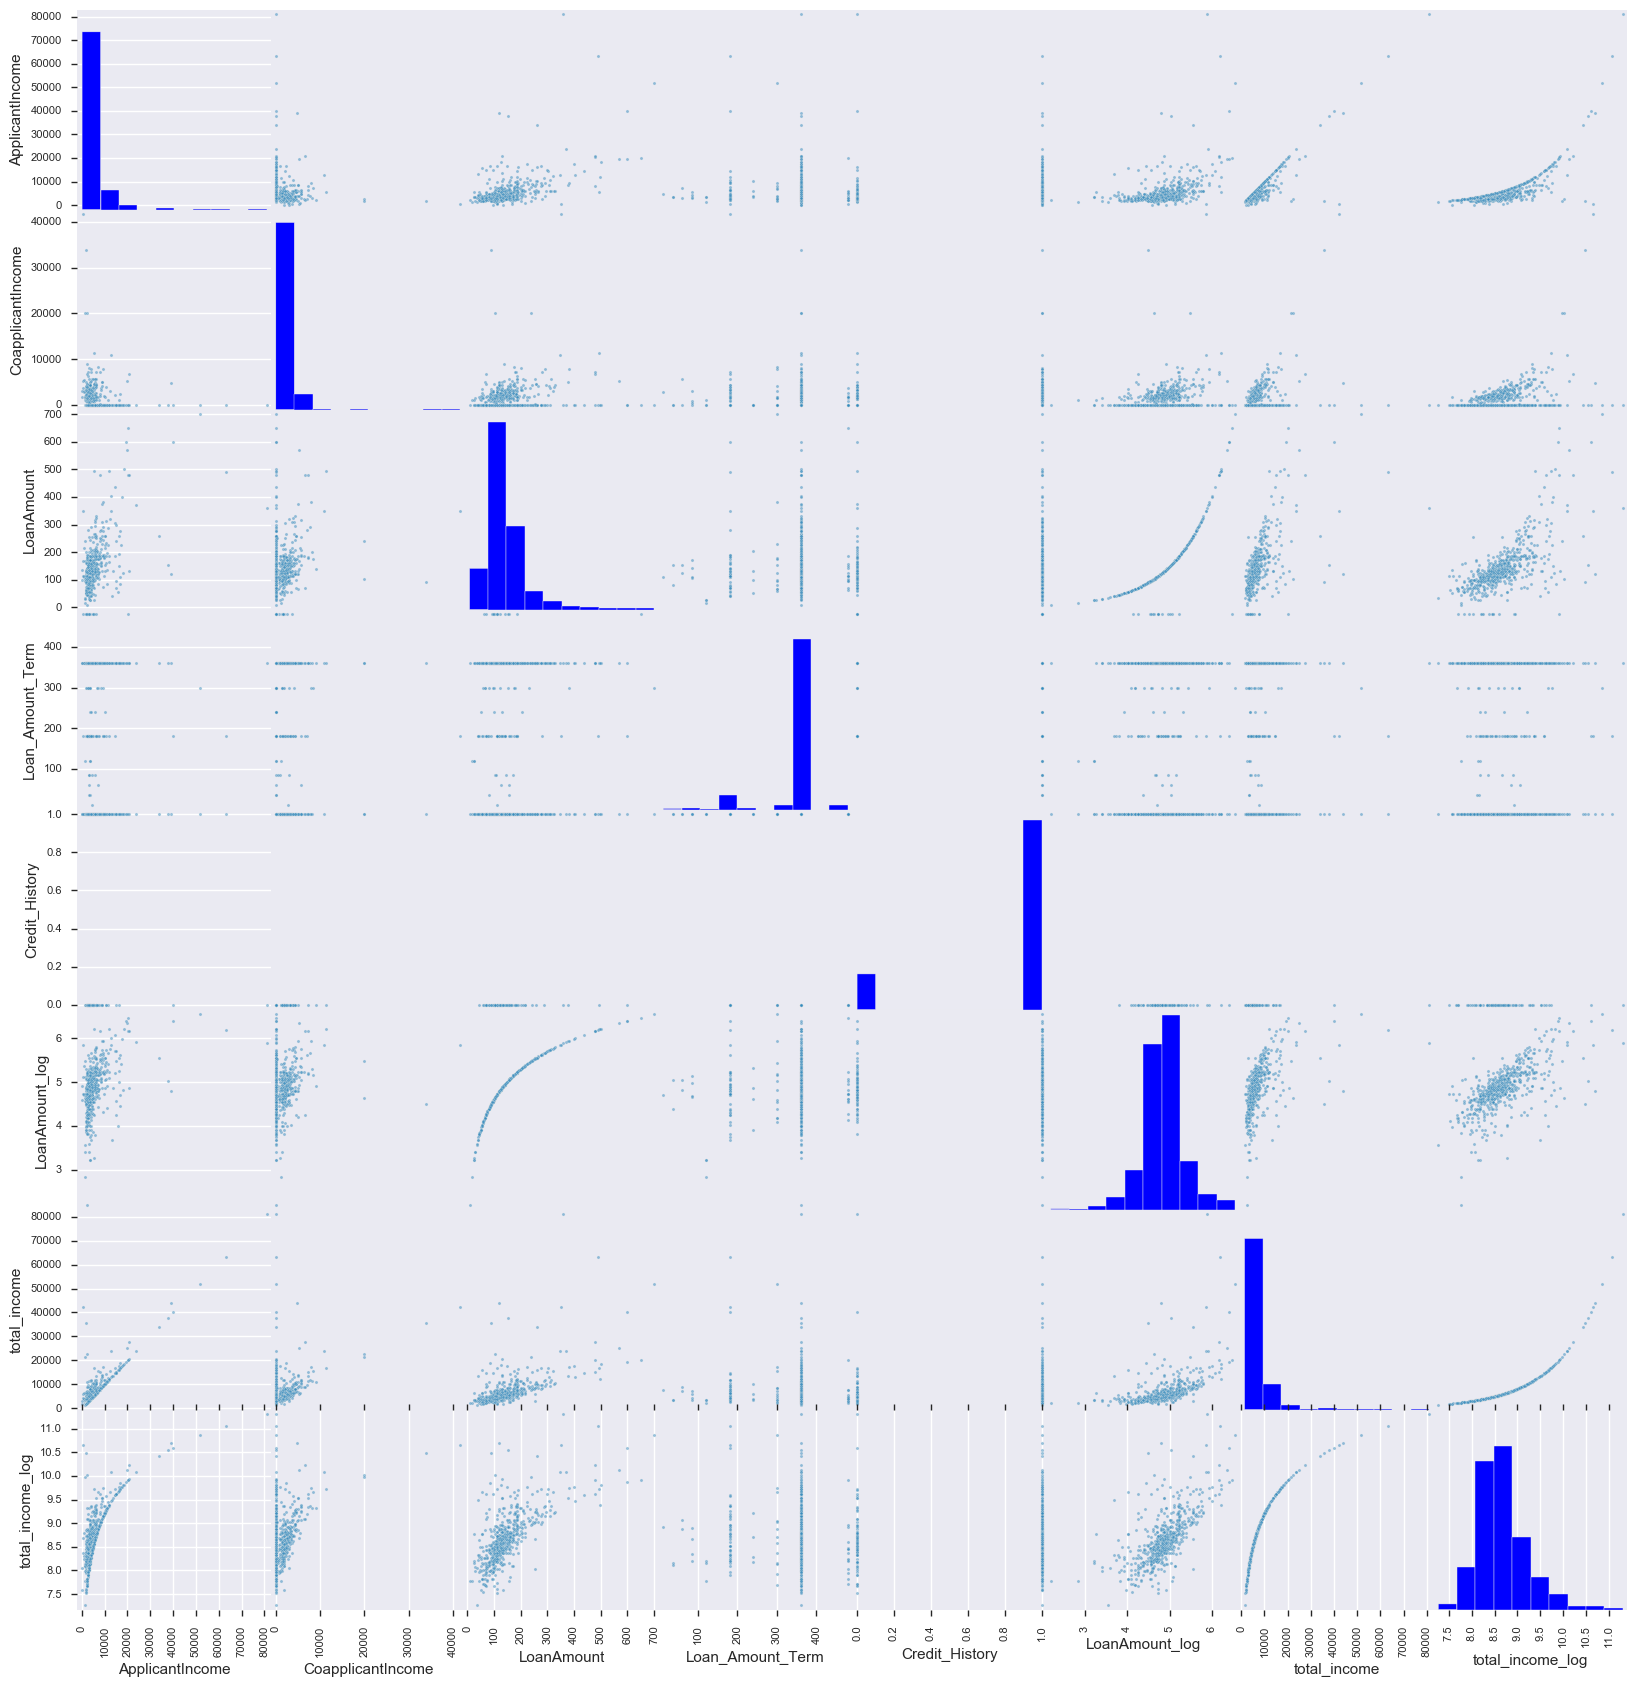

In [32]:
pd.scatter_matrix(df_train, figsize=(20, 20));

Can we find a variable that we can use to impute Credit_History

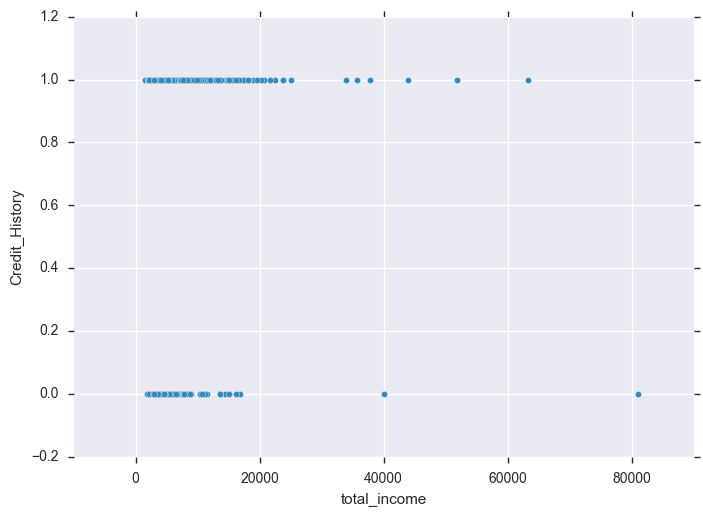

In [33]:
df_train[['Credit_History', "total_income"]].plot(kind="scatter", x="total_income", y="Credit_History")

That doesn't appear to work. Can we use clustering to predict a reasonable value?

We've got to convert the categorical variables first'

In [34]:
categoricals = ['Property_Area', 'Self_Employed', 'Married', 'Gender', 'Dependents']

In [35]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
lhe = LabelEncoder()
ohe = OneHotEncoder()

In [36]:
df_train[categoricals]

,Property_Area,Self_Employed,Married,Gender,Dependents
0,Urban,No,No,Male,0
1,Rural,No,Yes,Male,1
2,Urban,Yes,Yes,Male,0
3,Urban,No,Yes,Male,0
4,Urban,No,No,Male,0
5,Urban,Yes,Yes,Male,2
6,Urban,No,Yes,Male,0
7,Semiurban,No,Yes,Male,3+
8,Urban,No,Yes,Male,2
9,Semiurban,No,Yes,Male,1


In [37]:
df_train.Dependents.fillna(0, inplace=True)
df_train.Dependents = df_train.Dependents.str.replace("+", "")

In [38]:
df_train[categoricals].fillna(-1, inplace=True)

/Users/davidelks/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:2824: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [39]:
#We use the first step to turn the categorical strings into labels
#http://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn
#The apply method allows us to transform multiple columns
cat_labels = df_train[categoricals].apply(LabelEncoder().fit_transform)
categorical_variables = ohe.fit_transform(cat_labels)

/Users/davidelks/anaconda2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


In [40]:
numerics = ['total_income_log', 'LoanAmount_log', 'Loan_Amount_Term', "Credit_History"]

In [41]:
df_train[numerics].shape

(614, 4)

Right, we've got a dataset that has been preprocessed. Let's combine that, and then see if clustering on the data we've got allows us to predict Credit Score'

In [42]:
dense_cats = pd.DataFrame(categorical_variables.todense())

In [43]:
combined = pd.concat([df_train[numerics], dense_cats], axis=1) 

In [44]:
combined.head()


,total_income_log,LoanAmount_log,Loan_Amount_Term,Credit_History,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,8.674026,4.867534,360.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,8.714568,4.852030,360.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,8.006368,4.189655,360.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,8.505323,4.787492,360.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,8.699515,4.948760,360.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


Now let's remove the missing Credit History data, split the dataset and see what we get on clustering'

In [45]:
drops = combined.dropna(subset=["Credit_History"])
drops

,total_income_log,LoanAmount_log,Loan_Amount_Term,Credit_History,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,8.674026,4.867534,360.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,8.714568,4.852030,360.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,8.006368,4.189655,360.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,8.505323,4.787492,360.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,8.699515,4.948760,360.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
5,9.170872,5.587249,360.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
6,8.255569,4.553877,360.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
7,8.619750,5.062595,360.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
8,8.618305,5.123964,360.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9,10.077819,5.855072,360.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [46]:
X = drops.drop("Credit_History", axis=1)
X = X.fillna(-1).values # convert to numpy array
y = drops['Credit_History'].values


In [47]:
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
eval_size = 0.10
kf = StratifiedKFold(n_splits=2, random_state=42, shuffle=True) 
kf.get_n_splits(X, y)
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


In [48]:
from sklearn.tree import DecisionTreeClassifier
cls = DecisionTreeClassifier()
cls.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [49]:
preds = cls.predict(X_test)

In [50]:
from sklearn.metrics import classification_report

In [51]:
print classification_report(y_test, preds)

             precision    recall  f1-score   support

        0.0       0.15      0.16      0.16        44
        1.0       0.84      0.84      0.84       237

avg / total       0.73      0.73      0.73       281



In [52]:
from yellowbrick.classifier import ClassBalance, ClassificationReport, ClassificationScoreVisualizer, ROCAUC

/Users/davidelks/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


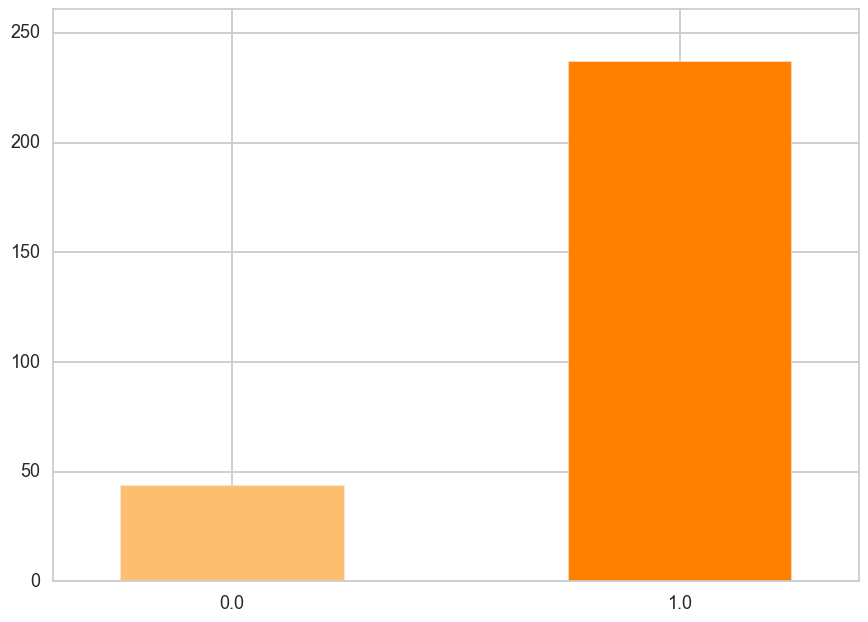

In [53]:
vis = ClassBalance(cls)
vis.fit(X_train, y_train)
vis.score(X_test, y_test)
g = vis.poof()

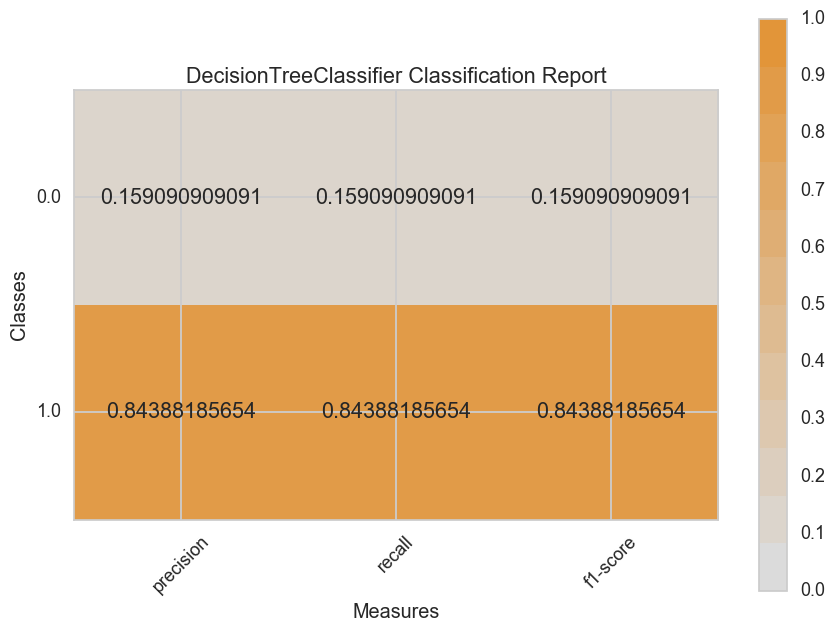

In [54]:
vis = ClassificationReport(cls)
vis.fit(X_train, y_train)
vis.score(X_test, y_test)
g = vis.poof()

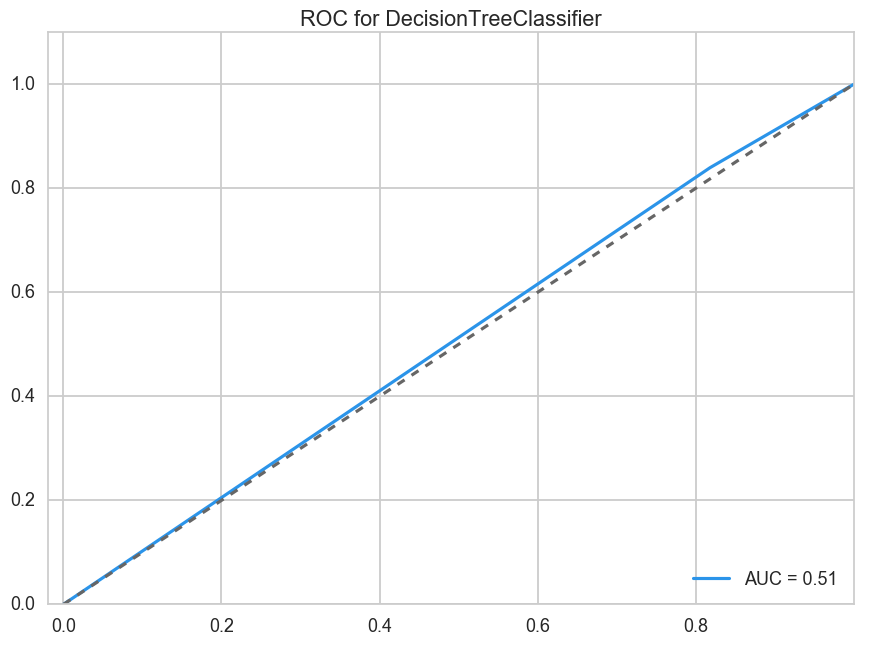

In [55]:
vis = ROCAUC(cls)
vis.fit(X_train, y_train)
vis.score(X_test, y_test)
g = vis.poof()

Not very happy with the graph, given that it indicates the classifier is little better than random chance. Let's try using the imblearn method to resample the data so that it's better balanced

In [56]:
from imblearn.over_sampling import SMOTE

In [57]:
smote = SMOTE()

In [58]:
X_resampled, y_resampled = smote.fit_sample(X, y)

Now rinse and repeat

In [59]:
kf = StratifiedKFold(n_splits=2, random_state=42, shuffle=True) 
kf.get_n_splits(X_resampled, y_resampled)
for train_index, test_index in kf.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]
    
cls = DecisionTreeClassifier()
cls.fit(X_train, y_train)
preds = cls.predict(X_test)
print classification_report(y_test, preds)

             precision    recall  f1-score   support

        0.0       0.76      0.76      0.76       237
        1.0       0.76      0.76      0.76       237

avg / total       0.76      0.76      0.76       474



Better... Although admittedly we've gained at the loss of scores for precision and recall

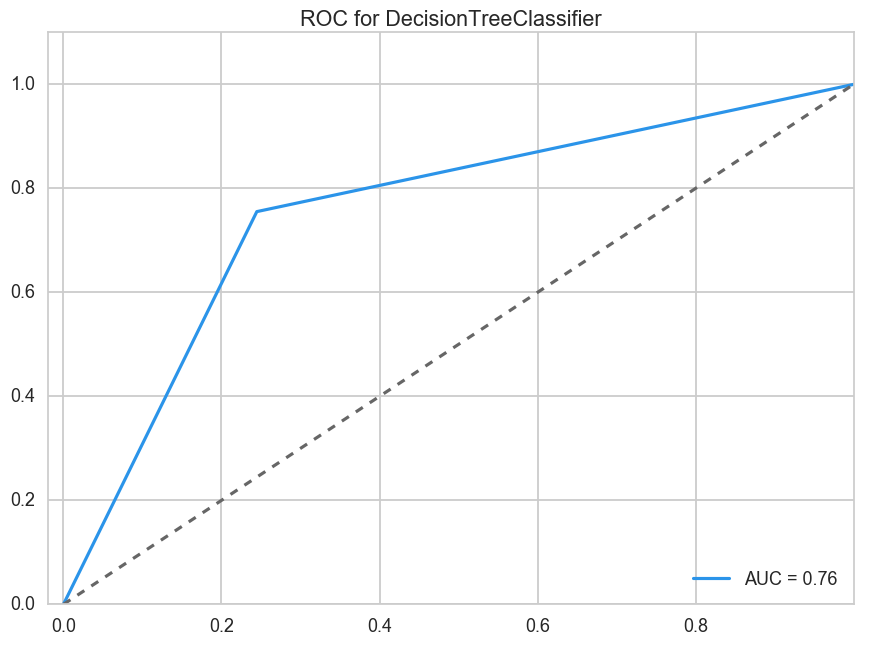

In [60]:
vis = ROCAUC(cls)
vis.fit(X_train, y_train)
vis.score(X_test, y_test)
g = vis.poof()

That's much better. We could probably look to tweak models to see whether we can get even better performance. 
But as the goal is further down, the line, let's stick to filling the missing data and generate a baseline from which we can improve

Of course, we've got to first abstract the process of reshaping data so we can push it through our model. Luckily, that's not that hard.

In [61]:
def fill_credit_history(dfr):
    if np.isnan(dfr['Credit_History']):
        print "filling"
    #Drop credit history as we will be filling that
        X = dfr.drop("Credit_History")
        X = X.fillna(-1).values # convert to numpy array
        return cls.predict(X.reshape(1, -1))[0]
    else:
        return dfr['Credit_History']
combined['Credit_History'] = combined.apply(fill_credit_history, axis=1)

filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling
filling


In [62]:
pandas_profiling.ProfileReport(combined)

Number of variables,20
Number of observations,614
Total Missing (%),0.1%
Total size in memory,96.0 KiB
Average record size in memory,160.1 B
Numeric,20
Categorical,0
Date,0
Text (Unique),0
Rejected,0
Distinct count,2


Right, we now need to refactor the code so we can apply the same steps to train and test data

In [97]:

from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

def process_data_frame(df):
    
    """Take the dataframe and then process it so it appears as it did in your exploration.
    It's a little ugly at this stage, but I'm still looking to refine the pipeline"""
    
    print df.shape
    #fill self-employed missing values
    df['Self_Employed'] = df['Self_Employed'].fillna("No")

    #This pivots median loan amounts into a table that we can use as a lookup table
    table = df.pivot_table(values='LoanAmount', index='Self_Employed',
                                 columns='Education', aggfunc="median")

    # Define function to return value of this pivot_table
    def fage(x):
        if np.isnan(x['LoanAmount']):
            return table.loc[x['Self_Employed'],x['Education']]
        else: 
            return x['LoanAmount']
    # Replace missing values
    
    df['LoanAmount'] = df.apply(fage, axis=1)


    #Create log transform of the Loan Amount data - so it's not skewed
    df['LoanAmount_log'] = np.log(df['LoanAmount'])

    # We can do something similar to the applicant income + and perhaps it combines with CoApplicant to recognise the influence of this person in obtaining a loan
    df['total_income'] = df.ApplicantIncome + df.CoapplicantIncome
    df['total_income_log'] = df.total_income.apply(lambda x: np.log(x))


    # Now to look at gender. The hunch is that there may be a link between loan amount and sex.
    piv = df.pivot_table(values='LoanAmount', index='Gender', aggfunc="median")
    def fill_func(data):
        return "Female" if abs(data['LoanAmount'] - 113) >= abs(data['LoanAmount'] - 130) else "Male"
    # Replace missing values
    df['LoanAmount'] = df['LoanAmount'].fillna(df[df['Gender'].isnull()].apply(fill_func, axis=1))


    # Can we find a variable that we can use to impute Credit_History

    categoricals = ['Property_Area', 'Self_Employed', 'Married', 'Gender', 'Dependents']


    # from sklearn.preprocessing import LabelEncoder, OneHotEncoder
    lhe = LabelEncoder()
    ohe = OneHotEncoder()



    df.Dependents.fillna(0, inplace=True)
    df.Dependents = df.Dependents.str.replace("+", "")

    df[categoricals].fillna(-1, inplace=True)

    #We use the first step to turn the categorical strings into labels
    #http://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn
    #The apply method allows us to transform multiple columns
    cat_labels = df[categoricals].apply(LabelEncoder().fit_transform)
    categorical_variables = ohe.fit_transform(cat_labels)

    numerics = ['total_income_log', 'LoanAmount_log', 'Loan_Amount_Term', "Credit_History"]


    dense_cats = pd.DataFrame(categorical_variables.todense())

    combined = pd.concat([df[numerics], dense_cats], axis=1) 

    
    drops = combined.dropna(subset=["Credit_History"])

    X = drops.drop("Credit_History", axis=1)
    X = X.fillna(-1).values # convert to numpy array
    y = drops['Credit_History'].values

    smote = SMOTE()

    X_resampled, y_resampled = smote.fit_sample(X, y)


    kf = StratifiedKFold(n_splits=2, random_state=42, shuffle=True) 
    kf.get_n_splits(X_resampled, y_resampled)
    for train_index, test_index in kf.split(X_resampled, y_resampled):
        X_train, X_test = X_resampled[train_index], X_resampled[test_index]
        y_train, y_test = y_resampled[train_index], y_resampled[test_index]
        
    cls = DecisionTreeClassifier()
    cls.fit(X_train, y_train)
    preds = cls.predict(X_test)
    

    def fill_credit_history(dfr):
        if np.isnan(dfr['Credit_History']):
            
        #Drop credit history as we will be filling that
            X = dfr.drop("Credit_History")
            X = X.fillna(-1).values # convert to numpy array
            return cls.predict(X.reshape(1, -1))[0]
        else:
            return dfr['Credit_History']
    combined['Credit_History'] = combined.apply(fill_credit_history, axis=1)
    print combined.shape
    return combined 




In [99]:
data_features = process_data_frame(df_train)
data_features.shape

(614, 16)
(614, 20)


(614, 20)

Right now to test some models. Let's build a framework to chuck a whole series of classifiers to see which one fits best'. What's the method?

    *Instantiate a method
    *Fit model
    *Make predictions
    *If we have true data with which to compare, return a score
    

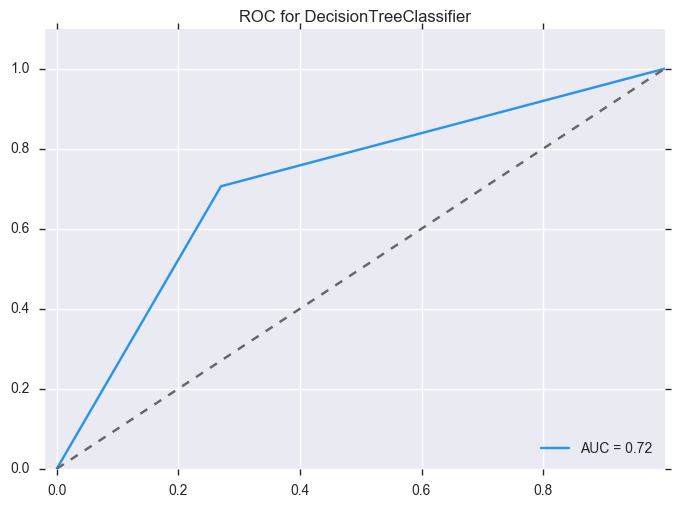

In [121]:
def train_model_pipeline(X, y, model):
    """I'm assuming that the parameters on the model have already been set and that I've prepared the data"""
    
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_sample(data_features.fillna(-1), outputs)


    kf = StratifiedKFold(n_splits=2, random_state=42, shuffle=True) 
    kf.get_n_splits(X_resampled, y_resampled)
    for train_index, test_index in kf.split(X_resampled, y_resampled):
            X_train, X_test = X_resampled[train_index], X_resampled[test_index]
            y_train, y_test = y_resampled[train_index], y_resampled[test_index]
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    #vis = ClassificationReport(model)
    #vis.fit(X_train, y_train)
    #vis.score(X_test, y_test)
    #g = vis.poof()
    
    vis2 = ROCAUC(model)
    vis2.fit(X_train, y_train)
    vis2.score(X_test, y_test)
    h = vis2.poof()

le = LabelEncoder()
outputs = le.fit_transform(df_train['Loan_Status'])
train_model_pipeline(data_features.fillna(-1), outputs, DecisionTreeClassifier())

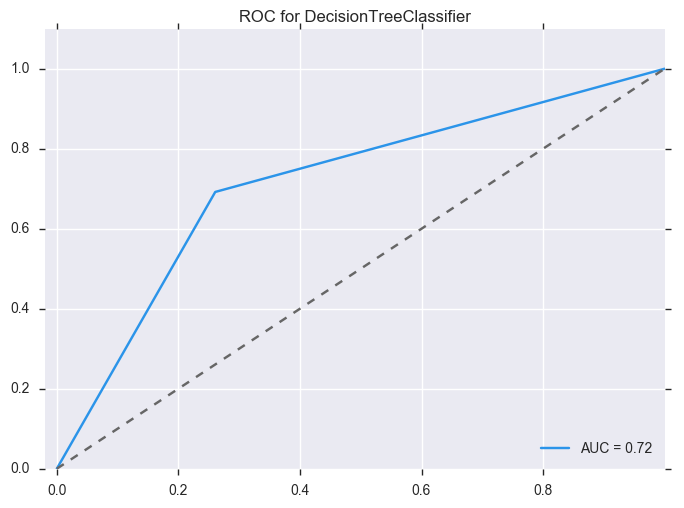

In [122]:
train_model_pipeline(data_features.fillna(-1), outputs, DecisionTreeClassifier())

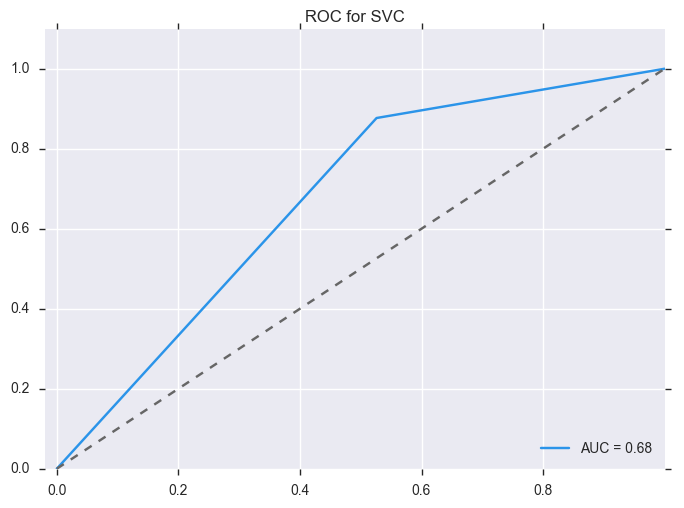

In [124]:
from sklearn.svm import SVC
train_model_pipeline(data_features.fillna(-1), outputs, SVC())

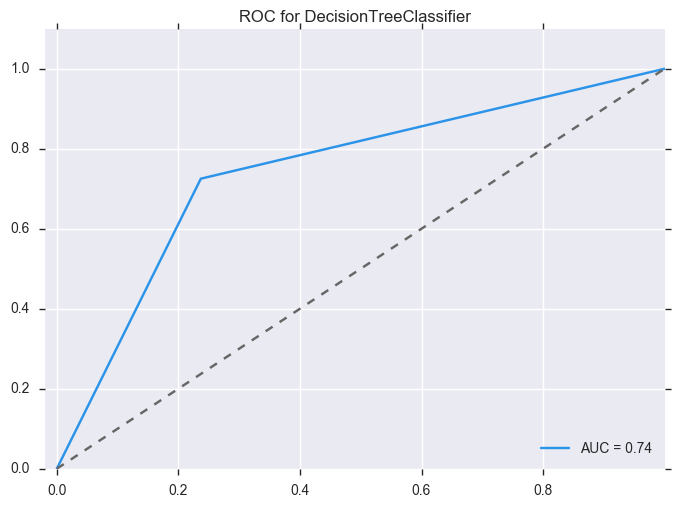

In [128]:

train_model_pipeline(data_features.fillna(-1), outputs, DecisionTreeClassifier())

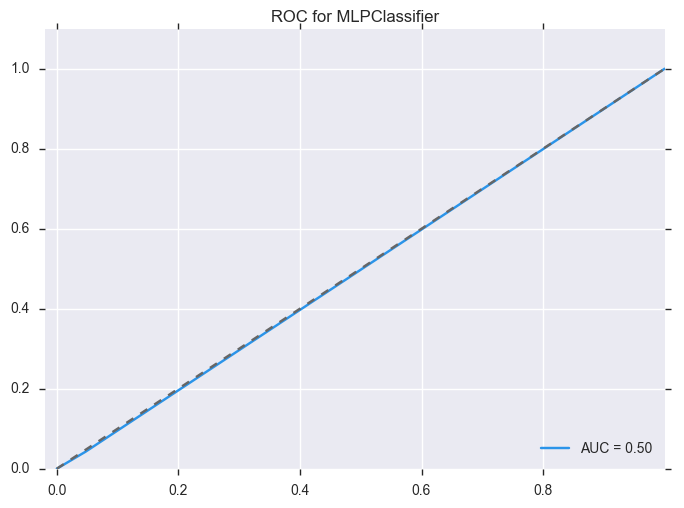

In [126]:
from sklearn.neural_network import MLPClassifier

train_model_pipeline(data_features.fillna(-1), outputs, MLPClassifier())

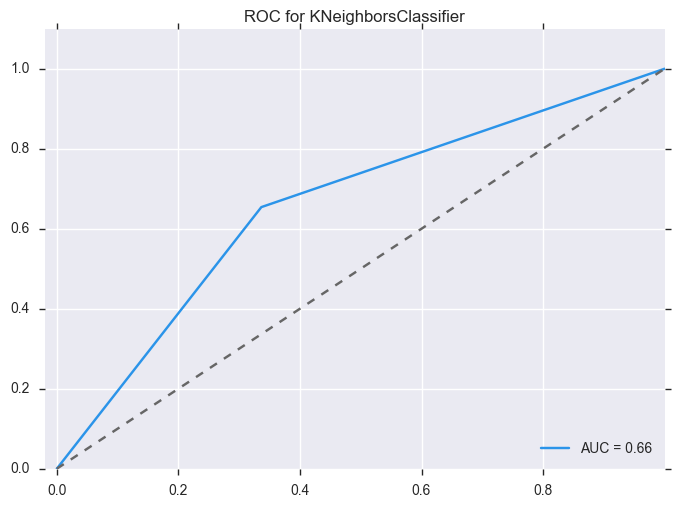

In [130]:
from sklearn.neighbors import KNeighborsClassifier
mod = KNeighborsClassifier()
train_model_pipeline(data_features.fillna(-1), outputs, mod)

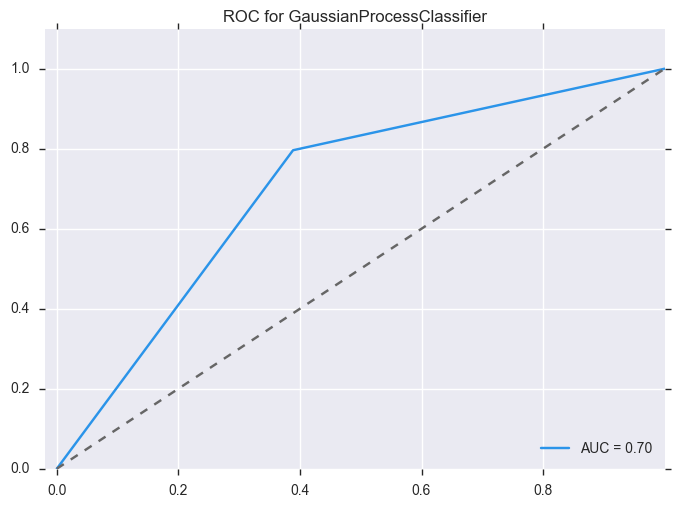

In [129]:
from sklearn.gaussian_process import GaussianProcessClassifier
mod = GaussianProcessClassifier()
train_model_pipeline(data_features.fillna(-1), outputs, mod)

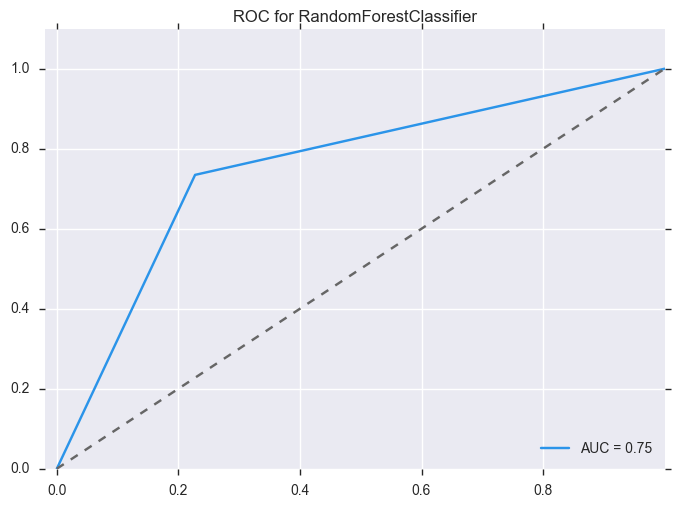

In [132]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
mod = RandomForestClassifier()
train_model_pipeline(data_features.fillna(-1), outputs, mod)

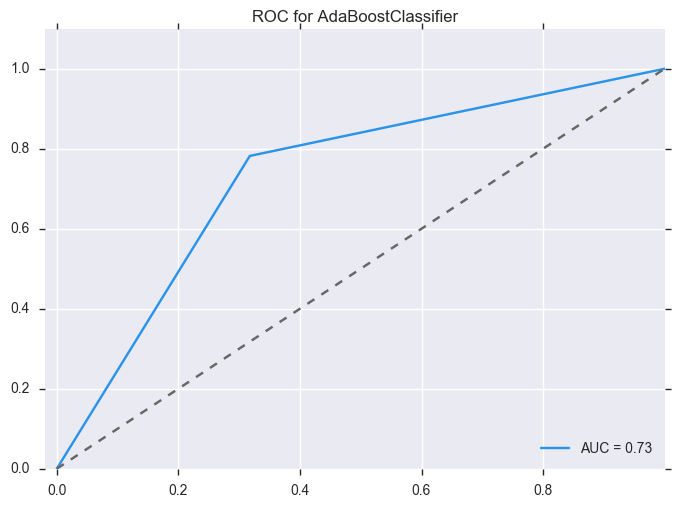

In [133]:
mod = AdaBoostClassifier()
train_model_pipeline(data_features.fillna(-1), outputs, mod)

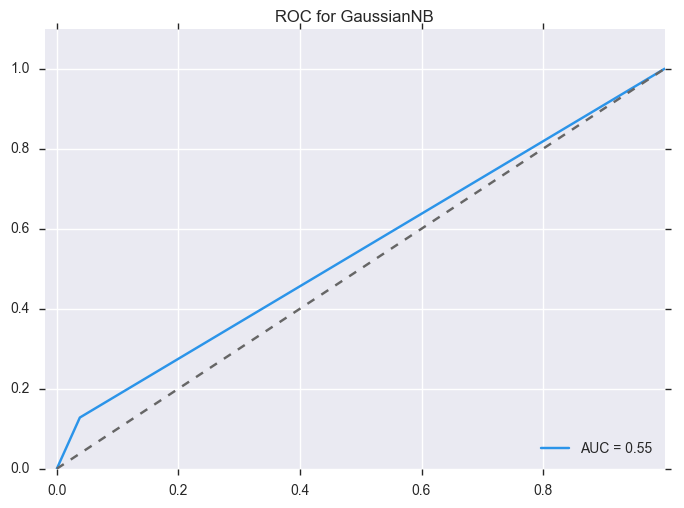

In [135]:
from sklearn.naive_bayes import GaussianNB
mod = GaussianNB()
train_model_pipeline(data_features.fillna(-1), outputs, mod)

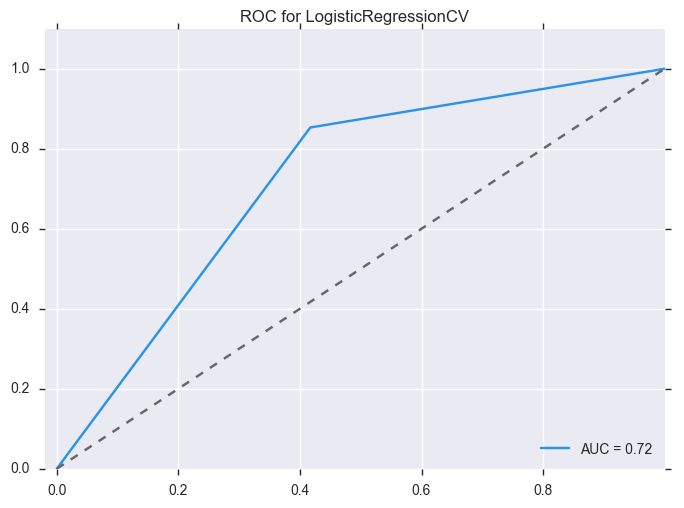

In [136]:
from sklearn.linear_model import LogisticRegressionCV
mod = LogisticRegressionCV()
train_model_pipeline(data_features.fillna(-1), outputs, mod)

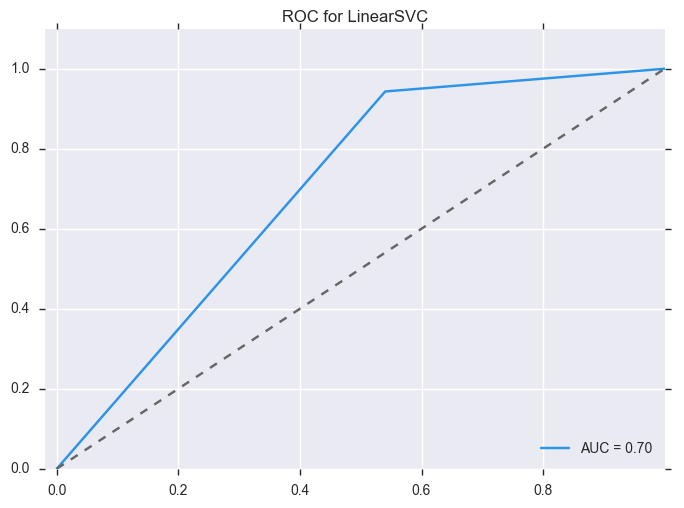

In [138]:
from sklearn.svm import LinearSVC
mod = LinearSVC()
train_model_pipeline(data_features.fillna(-1), outputs, mod)